In [204]:

import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
scaler = MinMaxScaler()
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM, TimeDistributed, Input
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from keras.saving import register_keras_serializable

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(0, len(dataset)-2 *look_back+1, look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back: i+ 2*look_back])
    return np.array(dataX), np.array(dataY)

def exponential_moving_average(data, span):
    return data.ewm(span=span, adjust=False).mean()

def read_data(file_path, num_features = 1):
    from pandas import read_csv
    series_influ_A_df = read_csv(file_path, index_col=0, engine='python')
    series_influ_A_df = series_influ_A_df.rename(columns= {"Influenza A - All types of surveillance": "case"})
    series_influ_A_df = series_influ_A_df[["case", "temp", "tempmax", "dew","windspeed"][:num_features]]
    return series_influ_A_df.dropna()

def prepare_data(series, look_back, scaler, is_ema = False):
    if is_ema:
        span = 52  # Bạn có thể điều chỉnh độ dài span tùy ý
        series['case'] = exponential_moving_average(series['case'], span)
    series = series.astype('float32')
    series = series.values
    if scaler is not None:
        flattened_dataset = series.flatten()
        dataset = scaler.fit_transform(flattened_dataset.reshape(-1,1))
        dataset = dataset.reshape(series.shape)

    else: 
        dataset = series

    rest = len(dataset) % look_back
    dataset = dataset[rest:, :]
    trainsize = len(dataset) - look_back
    train = dataset[:trainsize, :]
    test = dataset[trainsize - look_back:, :]

    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    return trainX, trainY, testX, testY

def forecast(input, model):
    predicted = model.predict(input, verbose=0)
    return predicted

In [205]:
@register_keras_serializable()
class MyLSTM (Sequential):
    def __init__(self, look_back, dense_units =[],unit=64, optimizer='adam',name='lstm'):
        super().__init__(name=name)
        self.look_back = look_back
        self.add(Input(shape=(look_back,1)))
        self.add(LSTM(units=unit, activation='relu', return_sequences=True))
        for unit in dense_units:
            self.add(Dense(units=unit, activation='relu'))
        self.add(TimeDistributed(Dense(units=5, activation='sigmoid' )))
        self.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    

def build_model(input_shape, dense_units = [], unit=64, optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=unit, activation='relu', return_sequences=True))
    for unit in dense_units:
        model.add(Dense(units=unit, activation='relu'))
    model.add(TimeDistributed(Dense(units=input_shape[1], activation='sigmoid' )))
    model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


In [206]:
df = read_data('../temp_data/influA_vietnam_last_10_days.csv')

In [207]:
# testY_hat = forecast(testX, model)

In [208]:
# y_hat_inverse = np.expand_dims(scaler.inverse_transform(testY_hat[0]), axis=0)
# y_inverse = np.expand_dims(scaler.inverse_transform(testY[0]), axis=0)


In [209]:
def plot(testY, forecasts):
    import matplotlib.pyplot as plt
    forecastsPlot = forecasts[:,:,0].reshape(-1)
    testPlot = testY[:,:,0].reshape(-1)
    plt.plot(testPlot, "-y", label="actual", marker= '.')
    plt.plot(forecastsPlot, color = 'green', label="forecast")
    plt.ylabel("Number of infections")
    plt.legend(["actual", "forecast"])
    plt.show()


In [210]:
# plot(y_inverse, y_hat_inverse)
# print(model.predict(trainX).shape)
# print(trainY.shape)
# forecasts = model.predict(trainX)
# plot(trainY, forecasts)

In [211]:
import itertools
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

def LSTM_HyperParameter_Tuning(config, df, scaler):
    
    n_neurons, n_batch_sizes, dropouts, look_backs = config
    possible_combinations = list(itertools.product(n_neurons, n_batch_sizes, dropouts, look_backs))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    for i in range(0, len(possible_combinations)):
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        n_neurons, n_batch_size, dropout, look_back = possible_combinations[i]

        trainX, trainY, testX, testY = prepare_data(df, look_back, scaler, is_ema=True)
        model = build_model(input_shape=(trainX.shape[1], trainX.shape[2]), dense_units=n_neurons[1:], unit=n_neurons[0])

        es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''
        file_path = '../model/best_lstm_many_to_many_model.keras'

        mc = ModelCheckpoint(file_path, monitor='loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        model.fit(trainX, trainY,batch_size=n_batch_size, callbacks=[es, mc], verbose=0, epochs=200)
        train_accuracy = model.evaluate(trainX, trainY, verbose=0)
        test_accuracy = model.evaluate(testX, testY, verbose=0)
        hist.append(list((n_neurons, n_batch_size, dropout,look_back,
                          train_accuracy, test_accuracy)))
        # print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy}')
        
        # print('--------------------------------------------------------------------')
        # print('--------------------------------------------------------------------')
        # print('--------------------------------------------------------------------')
        # print('--------------------------------------------------------------------')
         
    return hist

In [212]:
config = [[[64,32,16], [32,16], [64], [32]], [8, 16, 32], [0.2],[12,15,17]]  
hist = LSTM_HyperParameter_Tuning(config, df, scaler)

[([64, 32, 16], 8, 0.2, 12), ([64, 32, 16], 8, 0.2, 15), ([64, 32, 16], 8, 0.2, 17), ([64, 32, 16], 16, 0.2, 12), ([64, 32, 16], 16, 0.2, 15), ([64, 32, 16], 16, 0.2, 17), ([64, 32, 16], 32, 0.2, 12), ([64, 32, 16], 32, 0.2, 15), ([64, 32, 16], 32, 0.2, 17), ([32, 16], 8, 0.2, 12), ([32, 16], 8, 0.2, 15), ([32, 16], 8, 0.2, 17), ([32, 16], 16, 0.2, 12), ([32, 16], 16, 0.2, 15), ([32, 16], 16, 0.2, 17), ([32, 16], 32, 0.2, 12), ([32, 16], 32, 0.2, 15), ([32, 16], 32, 0.2, 17), ([64], 8, 0.2, 12), ([64], 8, 0.2, 15), ([64], 8, 0.2, 17), ([64], 16, 0.2, 12), ([64], 16, 0.2, 15), ([64], 16, 0.2, 17), ([64], 32, 0.2, 12), ([64], 32, 0.2, 15), ([64], 32, 0.2, 17), ([32], 8, 0.2, 12), ([32], 8, 0.2, 15), ([32], 8, 0.2, 17), ([32], 16, 0.2, 12), ([32], 16, 0.2, 15), ([32], 16, 0.2, 17), ([32], 32, 0.2, 12), ([32], 32, 0.2, 15), ([32], 32, 0.2, 17)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: loss improved from inf to 0.07993, saving model

In [213]:
import pandas as pd
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[4], ascending=True)
hist

,0,1,2,3,4,5
27,[32],8,0.2,12,"[0.0007833415293134749, 0.027988238260149956]","[0.006738580763339996, 0.08208885788917542]"
18,[64],8,0.2,12,"[0.001734639168716967, 0.041648998856544495]","[0.0028570133727043867, 0.053451038897037506]"
20,[64],8,0.2,17,"[0.0026599576231092215, 0.05157477781176567]","[0.004812012426555157, 0.06936866790056229]"
29,[32],8,0.2,17,"[0.0027057917322963476, 0.052017226815223694]","[0.012027062475681305, 0.10966796427965164]"
10,"[32, 16]",8,0.2,15,"[0.003351793857291341, 0.05789468064904213]","[0.0067892917431890965, 0.08239715546369553]"
9,"[32, 16]",8,0.2,12,"[0.0035765962675213814, 0.05980465188622475]","[0.002344176173210144, 0.04841669276356697]"
22,[64],16,0.2,15,"[0.003833445953205228, 0.061914827674627304]","[0.006392961833626032, 0.07995600253343582]"
3,"[64, 32, 16]",16,0.2,12,"[0.003960134461522102, 0.06292959302663803]","[0.0012462986633181572, 0.03530295565724373]"
15,"[32, 16]",32,0.2,12,"[0.004113844130188227, 0.06413926184177399]","[0.004314422141760588, 0.0656842589378357]"
21,[64],16,0.2,12,"[0.004280174616724253, 0.06542304158210754]","[0.004931338131427765, 0.07022348791360855]"


In [214]:
def inverse_transform(data, scaler):
    flattened_data = data.flatten()
    inverse_flattened_data = scaler.inverse_transform(flattened_data.reshape(-1,1))
    return inverse_flattened_data.reshape(data.shape)

In [226]:
from keras.models import load_model

model = load_model("../model/best_lstm_many_to_many_model.keras")
df = read_data('../temp_data/influA_vietnam_last_10_days.csv')
trainX, trainY, testX, testY = prepare_data(df, 17, scaler, is_ema=True)
model.evaluate(testX, testY)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.1039 - root_mean_squared_error: 0.3223


[0.10388263314962387, 0.3223083019256592]

In [216]:
# hist.iloc[0][3]

12

In [217]:


# testY_hat = forecast(testX, model)
# y_hat_inverse = np.expand_dims(scaler.inverse_transform(testY_hat[0]), axis=0)
# y_inverse = np.expand_dims(scaler.inverse_transform(testY[0]), axis=0)

In [227]:


testY_hat = forecast(testX, model)
y_hat_inverse = inverse_transform(testY_hat, scaler)
y_inverse = inverse_transform(testY, scaler)

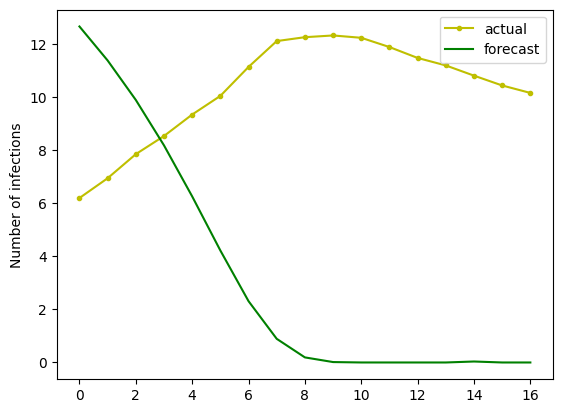

In [228]:
plot(y_inverse, y_hat_inverse)

In [220]:
df = read_data('../temp_data/influA_vietnam_last_10_days.csv')
trainX, trainY, testX, testY = prepare_data(df, hist.iloc[0][3], scaler=None, is_ema=True)
testY

array([[[10.055818],
        [11.148051],
        [12.123596],
        [12.269876],
        [12.335164],
        [12.247045],
        [11.898099],
        [11.48685 ],
        [11.204328],
        [10.819259],
        [10.448721],
        [10.167637]]], dtype=float32)

In [225]:
print(hist.iloc[0][3])
model.summary()

12


Model: "sequential_221"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_223 (LSTM)                 │ (None, 17, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_223            │ (None, 17, 1)          │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,157 (51.40 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,772 (34.27 KB)

In [221]:
import numpy as np

# Set the random state for reproducibility
random_state = np.random.RandomState(seed=42)
tmp_scaler = MinMaxScaler()
# Generate random numbers using the random state
random_numbers = random_state.rand(1,5,5)
print("Original :", random_numbers)

scaled_data = tmp_scaler.fit_transform(random_numbers.flatten().reshape(-1,1)).reshape(random_numbers.shape)
print("scaled data :", scaled_data)

inverse_data = (tmp_scaler.inverse_transform(scaled_data.flatten().reshape(-1, 1))).reshape(random_numbers.shape)
print("inverse data :", inverse_data)

Original : [[[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]
  [0.15599452 0.05808361 0.86617615 0.60111501 0.70807258]
  [0.02058449 0.96990985 0.83244264 0.21233911 0.18182497]
  [0.18340451 0.30424224 0.52475643 0.43194502 0.29122914]
  [0.61185289 0.13949386 0.29214465 0.36636184 0.45606998]]]
scaled data : [[[0.37284965 0.9797798  0.74938422 0.60893137 0.14266357]
  [0.14263816 0.03950081 0.89072903 0.61151903 0.72418595]
  [0.         1.         0.85519484 0.20199041 0.16984743]
  [0.17151129 0.2987993  0.53108445 0.4333188  0.28509156]
  [0.62283009 0.12525671 0.28605594 0.36423482 0.45873155]]]
inverse data : [[[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]
  [0.15599452 0.05808361 0.86617615 0.60111501 0.70807258]
  [0.02058449 0.96990985 0.83244264 0.21233911 0.18182497]
  [0.18340451 0.30424224 0.52475643 0.43194502 0.29122914]
  [0.61185289 0.13949386 0.29214465 0.36636184 0.45606998]]]
